In [41]:
import random

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
# import albumentations as A
# from albumentations import CenterCrop, Compose, Resize

import cv2

In [42]:
print(cv2.__version__)

4.9.0


In [43]:
TRAIN_ROOT_DIR = Path('/home/onkar/DATASET/carvana-image-masking-challenge/train')
PROCESSED_IMAGES_DIR = Path('/home/onkar/DATASET/carvana-image-masking-challenge/processed/')

/home/onkar/DATASET/carvana-image-masking-challenge/train/train/6ba36af67cb0_02.jpg


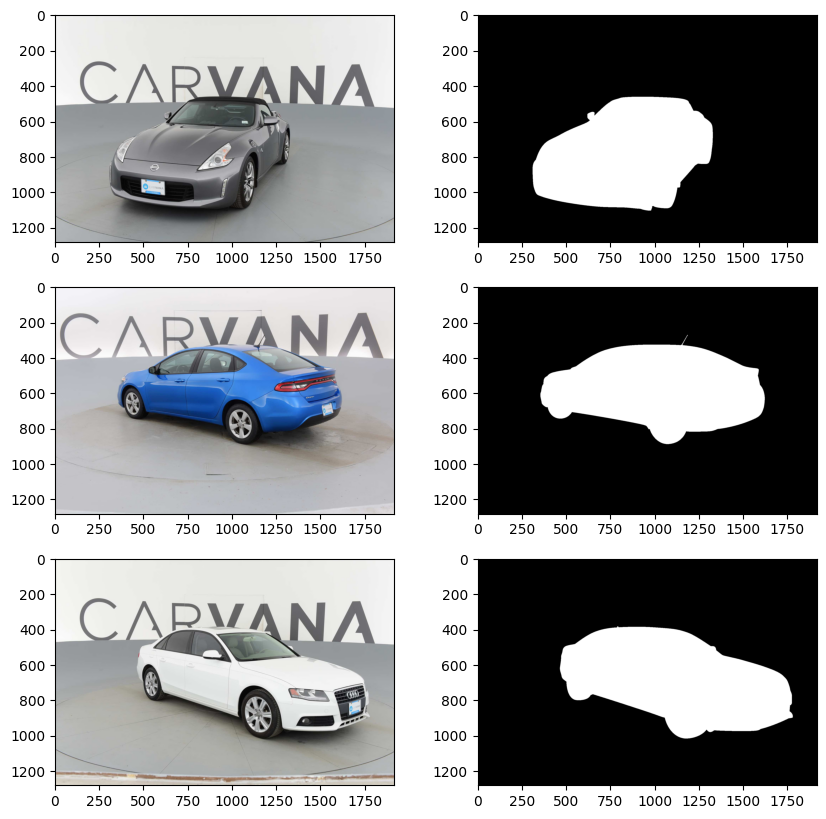

In [44]:
def create_file_list(root_dir, num_files=None):
    train_dir = root_dir/'train'
    mask_dir  = root_dir/'train_masks'
    
    all_files = []

    for img_fl in train_dir.glob('*.jpg'):
        pair = []
        mask_fl = img_fl.with_stem(img_fl.stem + '_mask').with_suffix('.gif')
        
        parts = list(mask_fl.parts)
        parts[-2] = 'train_masks'
        mask_fl = Path(*parts)
        
        # print(f'Image file : {img_fl}, Mask file : {mask_fl}')
        all_files.append((img_fl, mask_fl))

    random.shuffle(all_files)
        
    return all_files

## -- all_files are all the pair of files (image, mask --  
all_files = create_file_list(TRAIN_ROOT_DIR)

print(all_files[0][0])
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
    for j in range(2):
        img = Image.open(all_files[i][j])
        axes[i][j].imshow(img)
plt.show()

If you're using a U-Net model to create a mask for an image and you're getting unwanted noise in the output (as shown in the mask on the right), there are several approaches you can take to clean up the mask:

1. **Thresholding**: You can apply a threshold to the mask to remove low-intensity pixels which are likely to be noise. Pixels below a certain intensity value can be set to zero.

2. **Morphological Operations**: Use morphological operations like opening (erosion followed by dilation) to remove small noise points.

3. **Connected Component Analysis**: Identify and keep only the largest connected component in the mask, assuming the largest component corresponds to the main object (the car).

4. **Manual Cropping**: If the noise is always in the same area, as suggested by the pixel value cutoff above 1750, you can manually crop the mask as previously described.

Here's a Python code example using OpenCV that demonstrates the first three methods:

```python
import cv2
import numpy as np

# Assuming 'mask' is the output from the U-Net model as a NumPy array
# Apply thresholding to remove low-intensity noise
_, thresholded_mask = cv2.threshold(mask, thresh=127, maxval=255, type=cv2.THRESH_BINARY)

# Apply morphological opening to remove small noise points
kernel = np.ones((5,5), np.uint8
```

  0%|          | 0/5088 [00:00<?, ?it/s]

Image size : (320, 480, 3), Mask size : (320, 480)
Image size : (320, 480, 3), Mask size : (320, 480)
Image size : (320, 480, 3), Mask size : (320, 480)


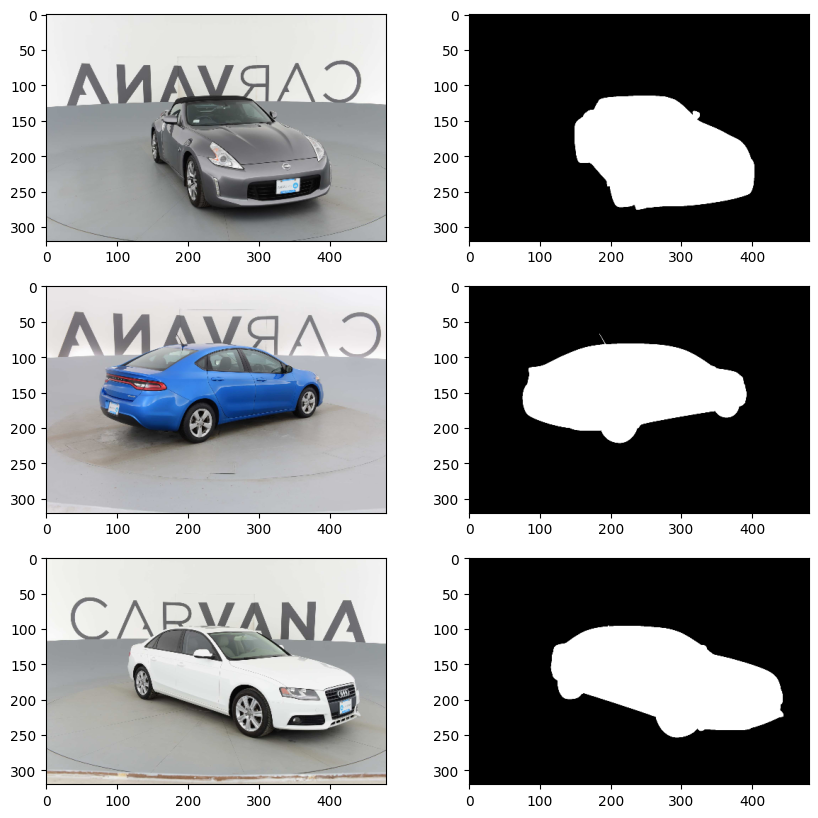

In [45]:
from PIL import Image

## Define transformations

def resize(image, mask, scale=1.0):
    return cv2.resize(image, (0, 0), fx=scale, fy=scale), cv2.resize(mask, (0, 0), fx=scale, fy=scale)

def rotate(image, mask, angle=45, scale=1.0):
    height, width = image.shape[:2]
    
    center = (width // 2, height // 2)
    
    rot_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    rot_image = cv2.warpAffine(image, rot_matrix, (width, height))
    rot_mask  = cv2.warpAffine(mask, rot_matrix, (width, height))
    
    return rot_image, rot_mask

def normalize(image, mask):
    
    normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return normalized_image, normalized_mask

def apply_sobel(image):
    # Apply Sobel filter
    sobelx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    
    return cv2.bitwise_or(sobelx, sobely)

def apply_canny(image):
    # Apply Canny edge detector
    return cv2.Canny(image, threshold1=50, threshold2=100)

def transform(image_path, mask_path):
    # print(f'Image path : {image_path}, Mask path : {mask_path}')
    
    image = cv2.imread(str(image_path))
    
    # --- Read the images into a numpy array ---
    # Masks are in *.gif format which is not supported by cv2, so we have to give cv2 numpy  array
    mask = cv2.imread(str(mask_path))
    if mask is None:
        mask = Image.open(mask_path)
        if mask.mode != 'RGB':
            mask_rgb = mask.convert('RGB') 

        mask_np = np.array(mask_rgb)

        mask = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY)
    # ## --- at this point image and mask are ready to be transformed into numpy arrays with BGR channels --
    
    ## Resize to 25%
    scale = 0.25
    image, mask = resize(image, mask, scale)
    
    # ## Rotate by 45 deg on left and right 
    # image, mask = rotate(image, mask)
   
    # ## Normalize the image
    image, mask = normalize(image, mask) 
    
    # ## Enhance edges
    # image = apply_sobel(image)
    # # mask = apply_sobel(mask)
    
    flipped_horizantally = False
    flip_prob = random.random()
    if flip_prob <= 0.5:
        image = cv2.flip(image, 1)
        mask  = cv2.flip(mask, 1)
        flipped_horizantally = True
    
    flip_prob = random.random()
    if flip_prob <= 0.5 and flipped_horizantally == False:
        image = cv2.flip(image, 0)
        mask  = cv2.flip(mask, 0)
    
    # Finally, convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image, mask

dataset_len = len(all_files)

# Save the processed files in *.npy format
def save_processed_files():
    for counter, (image_path, mask_path) in enumerate(tqdm(all_files)):
        # print(f'counter : {counter}, pair : {image, mask}')
        
        image, mask = transform(image_path, mask_path)

        target_dir = 'train' if counter < int(dataset_len*0.7) else 'val'
        save_path = PROCESSED_IMAGES_DIR/target_dir

        image_save_path = save_path/'images'
        mask_save_path = save_path/'masks'
        
        image_save_path.mkdir(parents=True, exist_ok=True)
        mask_save_path.mkdir(parents=True, exist_ok=True)
        
        # print(f'Saving image {image} at : {image_save_path}')
        np.save(image_save_path/image_path.name.replace('jpg', 'npy'), image)
        
        # print(f'Saving mask {mask} at : {mask_save_path}')
        np.save(mask_save_path/mask_path.name.replace('gif', 'npy'), mask)

save_processed_files()  
        
ll = all_files[:3]
# -------- TESTING PURPOSE ONLY -------------
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
    image_path, mask_path = ll[i]
    
    image, mask = transform(image_path, mask_path)
    print(f'Image size : {image.shape}, Mask size : {mask.shape}')
    axes[i][0].imshow(image)
    axes[i][1].imshow(mask, cmap='gray')
plt.show()